In [3]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import statsmodels.api as sm

In [4]:
town = 'WOODLANDS'
flat_type = '4 ROOM'

# Get the data
df_lstm = pd.read_csv("data/cleaned_final_data.csv")

# Filter the data to only include the selected town and flat type
df_lstm = df_lstm[(df_lstm['town'] == town) & (df_lstm['flat_type'] == flat_type)]

# Select the relevant columns and create a new DataFrame
df_lstm = df_lstm.loc[(df_lstm['town'] == town) & (df_lstm['flat_type'] == flat_type), 
                 ["resale_price", "year", "month", 'month_remaining_lease', 'floor_area_sqm', 'storey_range_high', 'min_dist_mrt', 'min_dist_town_in_km', 'cpi']].copy()

# Convert year and month columns to datetime format
df_lstm['date'] = pd.to_datetime(df_lstm['year'].astype(str) + '-' + df_lstm['month'].astype(str), format='%Y-%m')

# Set the date column as the index
df_lstm.set_index('date', inplace=True)

# Average the resale price, floor area, etc for data with the same date
df_lstm = df_lstm.groupby('date').mean()

# Order the data by date
df_lstm.sort_index(inplace=True)

# Normalize the data using Scaler
scaler = MinMaxScaler()
df_prices = df_lstm['resale_price']
df_lstm = pd.DataFrame(scaler.fit_transform(df_lstm), columns=df_lstm.columns, index=df_lstm.index)
scaler.fit_transform(df_prices.values.reshape(-1, 1))
df_lstm.head(5)

,resale_price,year,month,month_remaining_lease,floor_area_sqm,storey_range_high,min_dist_mrt,min_dist_town_in_km,cpi
date,,,,,,,,,
2017-01-01,0.185122,0.0,0.000000,0.381913,0.779186,0.456024,0.000000,0.367674,0.022568
2017-02-01,0.094815,0.0,0.090909,0.486994,0.082142,0.673888,0.934236,0.587565,0.022343
2017-03-01,0.170451,0.0,0.181818,0.566769,0.618330,0.826982,0.306719,0.479772,0.025427
2017-04-01,0.165910,0.0,0.272727,0.584547,0.692428,0.320350,0.455970,0.410470,0.002708
2017-05-01,0.096020,0.0,0.363636,0.347189,0.350114,0.759510,1.000000,0.834940,0.027985


In [5]:
# Split the data into training and testing sets
# The training set will have first 80% of the data
# The validation set will have next 10% of the data
# The testing set will have next 10% of the data
train_data = df_lstm.iloc[:int(df_lstm.shape[0]*0.8)]
val_data = df_lstm.iloc[int(df_lstm.shape[0]*0.8):int(df_lstm.shape[0]*0.9)]
test_data = df_lstm.iloc[int(df_lstm.shape[0]*0.9):]

# Define a function to create sequences of past observations and their target values
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data.iloc[i:(i+seq_length)].values)
        y.append(data.iloc[i+seq_length]['resale_price'])
    return np.array(X), np.array(y)

# Create sequences of past observations and their target values for training and testing sets
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Define and compile the LSTM model
model = Sequential()
# 3 layers LSTM with 64 hidden units
# model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, 9)))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(64, activation='relu'))
# model.add(Dense(1))
# 1 layer LSTM with 256 hidden units
model.add(LSTM(256, activation='relu', input_shape=(seq_length, 9)))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Epoch 1/100
4/4 [==============================] - 1s 76ms/step - loss: 0.0347 - val_loss: 0.2082
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0338 - val_loss: 0.1671
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0184 - val_loss: 0.1782
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0153 - val_loss: 0.1497
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0122 - val_loss: 0.0747
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0080 - val_loss: 0.0200
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 8/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0043 - val_loss: 0.0109
Epoch 11/100
4/4 [=

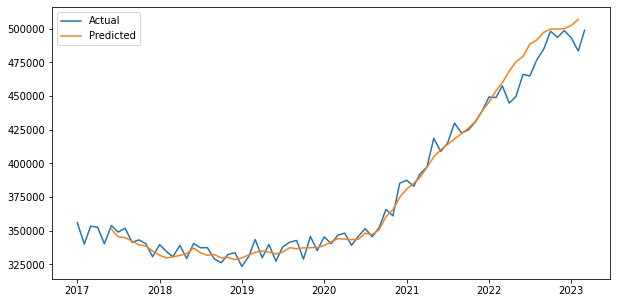

Mean Squared Error: 0.010384445077957837
Root Mean Squared Error: 0.10190409745421347
Mean Absolute Error: 0.09339767911027907
Coefficient of Determination (R^2): -12.459430289665656


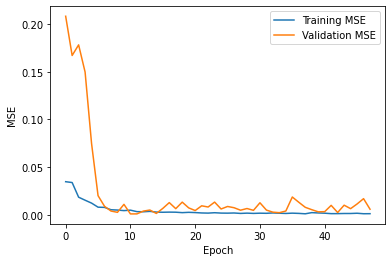

In [6]:
early_stop = EarlyStopping(monitor='loss', patience=10)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('training.log')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, callbacks=[early_stop, checkpoint, csv_logger], 
                    validation_data=(X_val, y_val), batch_size=15, verbose=1)

# Make predictions using the testing data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate the coefficient of determination (R^2)
r2 = r2_score(y_test, y_pred)

# Make predictions using the entire dataset
X_all, y_all = create_sequences(df_lstm, seq_length)
y_pred = model.predict(X_all)

# Un-normalize the data
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# Plot the predicted values with the actual values for the testing set
plt.figure(figsize=(10, 5))
plt.plot(df_prices.index, df_prices, label='Actual')
plt.plot(df_lstm.index[seq_length:-1], y_pred, label='Predicted')
plt.legend()
plt.show()
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('Coefficient of Determination (R^2):', r2)
log_df = pd.read_csv('training.log')
plt.plot(log_df['epoch'], log_df['loss'], label='Training MSE')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

1/1 [==============================] - 0s 14ms/step


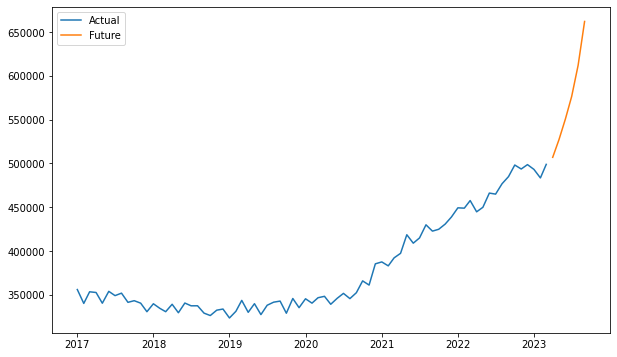

In [7]:
# Predition for next 4 months
future_values = []
# Get the last sequence of last 4 months
last_sequence = X_all[-1]
# Predict the next 4 months
for i in range(6):
    prediction = model.predict(last_sequence.reshape(1, seq_length, 9))
    future_values.append(prediction[0][0])
    last_sequence = np.concatenate((last_sequence[1:], np.repeat(prediction.reshape(1, 1), 9, axis=1)))

# Un-normalize the predicted values
future_prices = scaler.inverse_transform(np.array(future_values).reshape(-1, 1))

# Index for the future dates
future_dates = pd.date_range(start=df_lstm.index[-1], periods=7, freq='MS')[1:]
# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_prices.index, df_prices, label='Actual')
plt.plot(future_dates, future_prices, label='Future')
plt.legend()


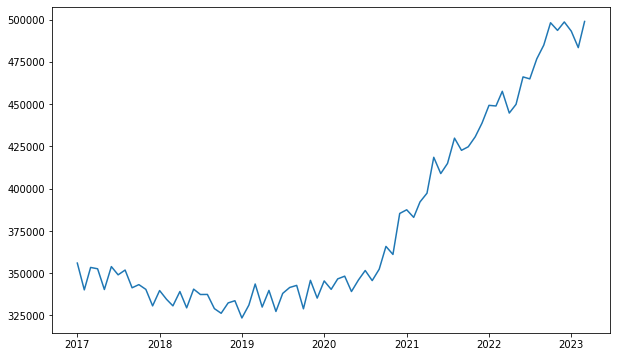

In [9]:
# Combine the predicted values with the actual values into a list
combined_values = df_lstm.iloc[:, 0].tolist()
combined_values.extend(future_values)
# Plot combined values
plt.figure(figsize=(10, 6))
plt.plot(df_prices.index, df_prices, label='Actual')
#plt.plot(df_lstm.index, combined_values, label='Combined')

In [10]:
town = 'WOODLANDS'
flat_type = '4 ROOM'

# Get the data
df_arima = pd.read_csv("data/cleaned_final_data.csv")

# Filter the data to only include the selected town and flat type
df_arima = df_arima[(df_arima['town'] == town) & (df_arima['flat_type'] == flat_type)]

# Select the relevant columns and create a new DataFrame
df_arima = df_arima.loc[(df_arima['town'] == town) & (df_arima['flat_type'] == flat_type), 
                 ["resale_price", "year", "month", 'month_remaining_lease', 'floor_area_sqm', 'storey_range_high', 'min_dist_mrt', 'min_dist_town_in_km', 'cpi']].copy()

# Convert year and month columns to datetime format
df_arima['date'] = pd.to_datetime(df_arima['year'].astype(str) + '-' + df_arima['month'].astype(str), format='%Y-%m')

# Set the date column as the index
df_arima.set_index('date', inplace=True)

# Average the resale price, floor area, etc for data with the same date
df_arima = df_arima.groupby('date').mean()

# Order the data by date
df_arima.sort_index(inplace=True)

df_arima['return'] = np.log(df_arima['resale_price']).diff()
df_arima = df_arima.dropna()
df_arima.index.freq = 'MS'

# Select the return column
df_arima = df_arima[['return']]
df_arima.head(5)

,return
date,
2017-02-01,-0.045505
2017-03-01,0.038252
2017-04-01,-0.002256
2017-05-01,-0.035375
2017-06-01,0.039063


c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.0004389347682359862
0.02095077011080944
0.016498173293445804


c:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


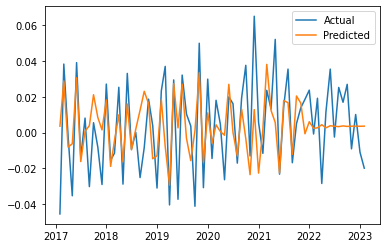

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 return   No. Observations:                   58
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 141.166
Date:                Fri, 21 Apr 2023   AIC                           -262.332
Time:                        22:33:25   BIC                           -241.728
Sample:                    02-01-2017   HQIC                          -254.306
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.003      1.169      0.242      -0.002       0.009
ar.L1         -0.2921      4.431     -0.066      0.947      -8.977       8.393
ar.L2          0.2770      1.029      0.269      0.788      -1.740       2.294
ar.L3          0.3255      1.919      0.170      0.865      -3.437       4.088
ar.L4         -0.0190      1.138     -0.017      0.987      -2.250       2.212
ma.L1         -0.3727      4.453     -0.084      0.933      -9.100       8.355
ma.L2         -0.1711      2.234     -0.077      0.939      -4.549       4.207
ma.L3          0.1444      1.329      0.109      0.913      -2.460       2.749
ma.L4          0.1437      1.401      0.103      0.918      -2.602       2.889
sigma2         0.0004   9.51e-05      4.686      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.92   Prob(JB):                         0.89
Heteroskedasticity (H):               1.59   Skew:                             0.15
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Split the data into training and testing sets
train_size = int(len(df_arima) * 0.8)
train, test = df_arima[:train_size], df_arima[train_size:]

# Define and fit the ARIMA model
model = sm.tsa.ARIMA(train, order=(4,0,4), freq='MS')
model_fit = model.fit()

# Make predictions on the test set
start_date = df_arima.index[0]
end_date = df_arima.index[-1]
predictions = model_fit.predict(start=start_date, end=end_date)

# Calculate the mean squared error
mse = mean_squared_error(df_arima['return'], predictions)
print(mse)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(rmse)

# Calculate the mean absolute error
mae = mean_absolute_error(df_arima['return'], predictions)
print(mae)

# Plot the predictions and actual values
plt.plot(df_arima.index, df_arima['return'], label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')
plt.legend()
plt.show()

# Show summary statistics of the model
model_fit.summary()